Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Weronika Pawlak"

---

In [2]:
import itertools
from typing import Collection, Dict, List, Optional, Tuple

from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from collections import defaultdict
from copy import deepcopy

C:\Users\User\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\User\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


# Ukryte Modele Markowa (*Hidden Markov Models*) - wprowadzenie

W odróżnieniu od dotychczas rozważanych problemów, przy danych sekwencyjnych mówimy o zbiorach obserwacji, których kolejność odgrywa istotną rolę. Przykładem takich danych są np. serie czasowe, czy też język naturalny.

W najprostszym podejściu moglibyśmy zignorować sekwencyjność danych (założyć, że są one *IID*) i potraktować jednym z dotychczasowych modeli. Przez zignorowanie zależności występujących pomiędzy kolejnymi krokami tracimy jednak istotne informacje, przez co możemy nie osiągnąć dobrych rezultatów.

## Model Markowa

Posłużymy się tutaj przykładem pogody. Załóżmy, że pogoda w danym dniu może być opisana zmienną losową, przyjmującą 3 wartości: $Z = \{słońce, deszcz, śnieg\}$. Zakładając, że dane są IID, jedyna informacja, na podstawie której możemy wnioskować z danych to względna częstość dni, gdy wystąpiły poszczególne zjawiska pogodowe. Pogoda jednak mocno zależy od trendów, które mogą trwać wiele dni.

Modelem pozwalającym wyrazić takie zależności jest Model Markowa (*Markov Model*). Opisuje on prawdopodobieństwo przejścia pomiędzy poszczególnymi stanami $Z = \{{z_0=słońce}, {z_1=deszcz}, {z_2=śnieg}\}$. Przykładowe prawdopodobieństwa przejść pomiędzy stanami zawarte zostały w tabelce:

| $$\Pr(z^{(t)} | z^{(t-1)})$$ | $$z^{(t-1)} = słońce$$ | $$z^{(t-1)} = deszcz$$ | $$z^{(t-1)} = śnieg$$  |
| :-: | :-: | :-: | :-: |
| $$z^{(t)} = słońce$$ | 0.75 | 0.18 | 0.07 |
| $$z^{(t)} = deszcz$$ | 0.45 | 0.52 | 0.03 |
| $$z^{(t)} = śnieg$$  | 0.77 | 0.04 | 0.19 |

![](assets/weather-obs.jpg)

W tak zdefiniowanym modelu łączne prawdopodobieństwo sekwencji obserwacji dane jest iloczynem:

$$P(z^{(1)}, \dots, z^{(T)}) = \prod_{t=1}^T P(z^{(t)} | z^{(1)}, \dots, z^{(t-1)}). \tag{1}$$

Zakładając, że rozkłady warunkowe są niezależne od wszystkich obserwacji z wyjątkiem ostatniej uzyskujemy proces Markowa pierwszego rzędu (*first-order Markov chain*). Wówczas wzór upraszcza się do postaci:

$$P(z^{(1)}, \dots, z^{(T)}) = P(z^{(1)}) \prod_{t=2}^T P(z^{(t)} | z^{(t-1)}). \tag{2}$$

Łańcuchy wyższego rzędu powstają przez uwzględnianie większej liczby poprzednich obserwacji.

Do obliczenia prawdopodobieństwa sekwencji obserwacji dla łańcucha pierwszego rzędu, oprócz macierzy przejść pomiędzy stanami (tabelka - $a$) potrzebować będziemy **rozkładu stanów początkowych** $\pi$, czyli prawdopodobieństw dla każdego z możliwych stanów na początku łańcucha.

## Ukryty Model Markowa

Rozwinięcie modeli Markowa, gdy zakładamy, że w modelu występują stany, których nie możemy obserwować (**stany ukryte** - *latent variables* $z$) oraz **obserwacje** (*observations*, czasem *evidence* $x$), które uzależnione są pewien sposób od tych stanów ukrytych. Rozszerzając wcześniejszy model, załóżmy że wcześniej wymienione stany są stanami ukrytymi; obserwować będziemy natomiast stroje kobiet: $X = \{{x_0=sukienka}, {x_1=płaszcz}, {x_2=parasol}\}$. Wtedy istotne będą, oprócz prawdopodobieństw przejścia, także prawdopodobieństwa **emisji**, czyli prawdopodobieństwa, że w danym stanie ukrytym zaobserwujemy daną obserwację:

$$b_{jk} = P(X=x_k | Z = z_j). \tag{3}$$

Wówczas rozszerzony model będzie wyglądał następująco:

![](assets/weather-hid.jpg)

Poniższa tabelka zawiera prawdopodobieństwa emisji:

| $$\Pr(x_k | z_j$$ | $$z_j = słońce$$ | $$z_j = deszcz$$ | $$z_j = śnieg$$  |
| :-: | :-: | :-: | :-: |
| $$x_k = sukienka$$ | 0.79 | 0.08 | 0.00 |
| $$x_k = płaszcz$$  | 0.13 | 0.25 | 0.92 |
| $$x_k = parasol$$  | 0.08 | 0.67 | 0.08 |

Ukryte Modele Markowa pozwalają nam na obliczanie łącznego prawdopodobieństwa sekwencji stanów ukrytych przy zadanej sekwencji stanów obserwowanych. Znając łączne prawdopodobieństwo sekwencji stanów ukrytych możemy określić ich najbardziej prawdopodobną sekwencję - znając sekwencję strojów kobiet w kilku kolejnych dniach oraz wspomniane wcześniej prawdopodobieństwa przejścia pomiędzy stanami ukrytymi, prawdopodobieństwa początkowe oraz prawdopodobieństwa emisji, będziemy mogli wnioskować na temat tego, jaka była pogoda w tych dniach.

*Źródła: C. M. Bishop: Pattern Recognition and Machine Learning (2006)*


## Definicja formalna

**Ukryty model Markowa** jest zdefiniowany jako pięcioelementowa krotka $(X, Z, \pi, a, b)$, gdzie:
- $X$ - zbiór obserwacji
- $Z$ - zbiór stanów ukrytych
- $\pi$ - rozkład prawdopodobieństwa stanów początkowych; $\pi_i = P(z^{(1)} = z_i)$ ($\pi_i$ oznacza prawdopodobieństwo  tego, że sekwencja stanów ukrytych rozpocznie się od stanu $z_i$)
- $a$ - macierz prawdopodobieństw przejść między stanami ukrytymi $a_{ij} = P(z^{(t)} = z_j | z^{(t-1)} = z_i)$ ($a_{ij}$ oznacza prawdopodobieństwo przejścia ze stanu $z_i$ do stanu $z_j$)
- $b$ - macierz prawdpodobieństw emisji $b_{jk} = P(x^{(t)} = x_k | z^{(t)} = z_j)$ ($b_{jk}$ oznacza prawdopodobieństwo obserwacji symbolu $x_k$ gdy model jest w stanie ukrytym $z_j$)

Indeks górny $t$ oznacza pozycję w sekwencji (ang. *timestamp*, *time step*).

Poniżej przykład dla kolejności aminokwasów w łańcuchu DNA:

![](assets/gene-hmm.png)

W tym przykładzie ukryty model Markova ma następujące parametry:
$$X = \{A, C, G, T\}$$

$$Z = \{H, L\}$$

$$\pi = [0.5, 0.5]$$

$$a = \begin{pmatrix} 0.5 & 0.5 \\ 0.4 & 0.6 \end{pmatrix}$$

$$b = \begin{pmatrix} 0.2 & 0.3 \\ 0.3 & 0.2 \\ 0.3 & 0.2 \\ 0.2 & 0.3\end{pmatrix}$$


*Źródło: https://www.cis.upenn.edu/~cis262/notes/Example-Viterbi-DNA.pdf*

Poniższa klasa zawiera przykładową implementację ukrytego modelu Markova - odpowiednik pięcioelementowej krotki.

In [3]:
class HMM:
    def __init__(
        self, 
        Z: Collection[str], 
        X: Collection[str], 
        init_dist: Optional[Dict[str, float]] = None, 
        transition_probs: Optional[Dict[Tuple[str, str], float]] = None, 
        emission_probs: Optional[Dict[Tuple[str, str], float]] = None,
    ):
        self.Z = Z  # Hidden states space
        self.X = X  # Observations space

        self.pi = init_dist  # P(z_0); z_0 -> p
        self.tr = transition_probs  # P(z_t | z_{t-1}); (z_t_1, z_t) -> p
        self.em = emission_probs  # P (x_t | z_t); (x_t, z_t) -> p
        
    @property
    def theta(self):
        return self.pi, self.tr, self.em
    
    @theta.setter
    def theta(self, values: tuple):
        self.pi, self.tr, self.em = values

Używając tej klasy możemy zdefiniować taki sam ukryty model Markova jak przedstawiono na powyższym rysunku:

In [4]:
def get_gene_hmm():
    _hmm = HMM(
        Z=('H', 'L'),
        X=('A', 'C', 'G', 'T'),
        init_dist={'H': 0.5, 'L': 0.5},
        transition_probs={
            ('H', 'H'): 0.5, ('H', 'L'): 0.5,
            ('L', 'L'): 0.6, ('L', 'H'): 0.4, 
        },
        emission_probs={
            ('A', 'H'): 0.2, ('C', 'H'): 0.3, ('G', 'H'): 0.3, ('T', 'H'): 0.2,
            ('A', 'L'): 0.3, ('C', 'L'): 0.2, ('G', 'L'): 0.2, ('T', 'L'): 0.3,
        }
    )

    return _hmm

def get_weather_hmm():
    _hmm = HMM(
        Z=('Rainy', 'Sunny'),
        X=('Walk', 'Shop', 'Clean'),
        init_dist={'Rainy': 0.6, 'Sunny': 0.4},
        transition_probs={
            ('Rainy', 'Rainy'): 0.7, ('Rainy', 'Sunny'): 0.3,
            ('Sunny', 'Rainy'): 0.4, ('Sunny', 'Sunny'): 0.6,
        },
        emission_probs={
            ('Walk', 'Rainy'): 0.1, ('Shop', 'Rainy'): 0.4, ('Clean', 'Rainy'): 0.5,
            ('Walk', 'Sunny'): 0.6, ('Shop', 'Sunny'): 0.3, ('Clean', 'Sunny'): 0.1,
        }
    )

    return _hmm

Wypiszmy parametry modelu w bardziej przystępnej formie:

In [5]:
def hmm_basic_info(hmm):
    """Displays parameters of given HMM."""
    # Initial distribution `pi`
    pi_df = pd.DataFrame(
        columns=[f'$$z^{{(0)}} = {z_0}$$' for z_0 in hmm.pi.keys()],
        index=["$$P(z^{{(0)}})$$"],
    )

    for z_0, p_z_0 in hmm.pi.items():
        pi_df[f'$$z^{{(0)}} = {z_0}$$']['$$P(z^{{(0)}})$$'] = p_z_0
        
    display(pi_df)
    
    # Transition matrix `a`
    a_df = pd.DataFrame(
        columns=[f'$$z^{{(t)}} = {dst}$$' for dst in hmm.Z],
        index=[f'$$z^{{(t-1)}} = {src}$$' for src in hmm.Z],
    )

    for (src, dst), val in hmm.tr.items():
        a_df[f'$$z^{{(t)}} = {dst}$$'][f'$$z^{{(t-1)}} = {src}$$'] = val
        
    display(a_df)
    
    # Emission matrix `b`
    b_df = pd.DataFrame(
        columns=[f'$$z^{{(t)}} = {z}$$' for z in hmm.Z],
        index=[f'$$x^{{(t)}} = {x}$$' for x in hmm.X],
    )

    for (x, z), val in hmm.em.items():
        b_df[f'$$z^{{(t)}} = {z}$$'][f'$$x^{{(t)}} = {x}$$'] = val
    
    display(b_df)

In [6]:
# HERE: zmień jeśli chcesz przeanalizować inne dane
hmm = get_gene_hmm()
# hmm = get_weather_hmm()

hmm_basic_info(hmm=hmm)

,$$z^{(0)} = H$$,$$z^{(0)} = L$$
$$P(z^{{(0)}})$$,0.5,0.5


,$$z^{(t)} = H$$,$$z^{(t)} = L$$
$$z^{(t-1)} = H$$,0.5,0.5
$$z^{(t-1)} = L$$,0.4,0.6


,$$z^{(t)} = H$$,$$z^{(t)} = L$$
$$x^{(t)} = A$$,0.2,0.3
$$x^{(t)} = C$$,0.3,0.2
$$x^{(t)} = G$$,0.3,0.2
$$x^{(t)} = T$$,0.2,0.3


# Prawdopodobieństwo obserwacji podanej sekwencji
W celu obliczenia prawdopodobieństwa $\mathbb{P}(x^{(1)}, \ldots, x^{(T)} |\theta)$ obserwacji danej sekwencji $x^{(1)}, \ldots, x^{(T)}$ dla modelu określonego za pomocą parametrów $\theta$, używa się tzw. algorytmu **Forward**. Wyniki obliczeń z kolejnych iteracji algorytmu $\alpha$ są często zapisywane w postaci tabelki:

$$\alpha = \forall_{z_j \in Z} \forall_{t \in \{1..T\}} \alpha_j(t)$$

Wiersze w tej tabeli odpowiadają stanom ukrytym modelu (tzn. mamy $|Z|$ wierszy), a kolumny - kolejnym obserwowanym symbolom (tzn. mamy $T$ kolumn, gdzie $T$ to długość sekwencji). Poniższy rysunek przestawia obliczenia dla poprzednio pokazanego przykładowego ukrytego modelu Markova (stany ukryte $Z = \{H, L\}$) oraz sekwencji $x^{(1)} = G, x^{(2)} = G, x^{(3)} = C, x^{(4)} =A$ ($T = 4$): 


![](assets/forward.png)

Na początku rozważamy pierwszy obserwowany symbol $x_1 = "G"$. Dla każdego możliwego początkowego stanu ukrytego $z_1$ obliczamy wartości $\alpha(1)$ jako iloczyny prawd. rozpoczęcia sekwencji stanów ukrytych od danego stanu (rozkład $\pi$) oraz prawd. emisji symbolu $x_1$ w tym stanie (macierz emisji $b$). Otrzymujemy zatem $|Z|$ wartości, które tworzą pierwszą kolumnę w tabelce. 

W kolejnych krokach algorytmu dla danej obserwacji $x^{(t)}$, będziemy zakładać, że w poprzednim kroku $t-1$ model mógł się znajdować w dowolnym stanie ukrytym $z^{(t-1)}$. Musimy zatem obliczyć iloczyn prawd. znajdywania się w danym stanie ukrytym, przejścia do obecnego stanu oraz emisji symbolu w danym stanie. Obliczone iloczyny z każdego poprzedniego stanu ukrytego dodajemy, aby otrzymać prawdopodobieństwo dla kroku $t$. 

$$
 \alpha_j(t) = 
  \begin{cases} 
   \pi_j b_{jk} & \text{if } t = 1 \\
   b_{jk} \sum_{z_i \in Z} \alpha_i(t - 1) a_{ij} & \text{if } t > 1
  \end{cases}
$$

Zakładamy, że w danym momencie $t$ obserwujemy symbol $x_k$ (stąd oznaczenie $b_{jk}$).

Ostatecznie prawdpodobieństwo obserwacji danej sekwencji $x^{(1)}, \ldots, x^{(T)}$ obliczamy jako sumę wartości w ostatniej kolumnie tabelki $\alpha$, tzn.

$$\mathbb{P}(x^{(1)}, \ldots, x^{(T)}|\theta) = \sum_{z_i \in Z} \alpha_i(T)$$


*Source: https://www.cis.upenn.edu/~cis262/notes/Example-Viterbi-DNA.pdf*

# Zadanie 1 (1.5 + 0.5 pkt)
**a)** Zaimplementuj, zgodnie z powyższym opisem, algorytm **Forward** - funkcja `forward()`. W celu uniknięcia problemów ze stabilnością numeryczną obliczaj logarytmy prawdopodobieństw. Wykorzystaj podaną funkcję `logsumexp()`.

In [7]:
def logsumexp(x):
    """Compute sum of log-probs using log-sum-exp trick."""
    x = np.array(x)
    x_max = max(x)
    return np.log(np.sum(np.exp(x - x_max))) + x_max

In [8]:
def forward(hmm: HMM, X: List[str]):
    """Implement the forward algorithm.

    :param hmm: Hidden Markov Model object.
    :param X: Sequence of elements of length T.
    :return: alpha. Dict of log-probabilities, where each key (t, z) denotes
        that any particular state z is chosen at the step t.
    """
    alpha = {}  # (t, z_j) -> log_p
    
    for t in range(len(X)):
        if t == 0:
            for state, init_prob in hmm.pi.items():
                alpha[t, state] = np.log(init_prob) + np.log(hmm.em[(X[t], state)])
        else:
            for current_state in hmm.Z:
                prob =[]
                for prev_state in hmm.Z:
                    prob.append(alpha[(t-1, prev_state)] + np.log(hmm.tr[(prev_state, current_state)]) + np.log(hmm.em[(X[t], current_state)]))
                alpha[(t, current_state)] = logsumexp(prob)


    return alpha

In [9]:
# testy ukryte


**b)** Następnie zaimplementuj funkcję `score_observation_sequence`, która oblicza prawdopodobieństwo obserwacji danej sekwencji $X = x^{(1)}, \ldots, x^{(T)}$ pod warunkiem parametrów modelu $\theta$. Tutaj również oblicz logarytm prawdpodobieństwa.

In [10]:
def score_observation_sequence(hmm: HMM, X: List[str]):
    """Computes the probability of observing a given sequence.

    :param hmm: Hidden Markov Model object.
    :param X: Sequence of elements of length T.
    :return: Tuple of log probability and alpha matrix calculated using
        `forward` step. Log probabilities are estimated as a sum of log
        probs over each possible state in the last step of alpha. Note, that
        these probabilities does not have to sum to one, since they
        describe probability of all paths leading to a particular state.
    """
    if any(param is None for param in hmm.theta):
        raise RuntimeError('Model must be trained first!')
    
    alpha = forward(hmm=hmm, X=X)
    x=[]
    for item in hmm.Z:
        x.append(alpha[(len(X)-1,item)])
    log_p = logsumexp(x)
    
    return log_p, alpha


In [11]:
# testy ukryte


In [12]:
def print_table(scores, T, Z, name):
    df = pd.DataFrame(
        columns=[f'$$t = {t}$$' for t in range(T)],
        index=[f'$$z = {z}$$' for z in Z],
    )

    for (t, z), v in scores.items():
        df[f'$$t = {t}$$'][f'$$z = {z}$$'] = np.round(v, 4)

    display(Markdown(f'### {name} table'))
    display(df)

In [13]:
# HERE: zmień jeśli chcesz przeanalizować inne dane
sample_X = ['G', 'G', 'C', 'A']
# sample_X = ['Walk', 'Clean', 'Clean', 'Clean', 'Shop']

log_p, alpha = score_observation_sequence(hmm=hmm, X=sample_X)
print(f'Log-Probability of observing X: {log_p} (actual probability: {np.exp(log_p)})')

print_table(scores=alpha, T=len(sample_X), Z=hmm.Z, name='Forward')

Log-Probability of observing X: -5.561462936154913 (actual probability: 0.0038431500000000026)


### Forward table

,$$t = 0$$,$$t = 1$$,$$t = 2$$,$$t = 3$$
$$z = H$$,-1.8971,-3.3668,-4.7777,-6.5881
$$z = L$$,-2.3026,-3.6119,-5.0071,-6.005


# Dekodowanie Viterbiego
Kolejnym zadaniem związanym z ukrytym modelem Markova jest znajdywanie najbardziej prawdopodobnej sekwencji stanów ukrytych $Z_{max}$ dla podanej sekwencji obserwacji $X$. 

$$Z_{max} = \max_{z^{(1)}, \ldots, z^{(T)}} \mathbb{P}(z^{(1)},z^{(2)},\ldots,z^{(T)}, x^{(1)},x^{(2)}, \ldots, x^{(T)} | \theta)$$

Stosowany jest tutaj algorytm **dekodowania Viterbiego** (*Viterbi decoding*). Działa on na podobnej zasadzie jak algorytm **Forward**, przy czym zamiast obliczać sumę po wszystkich poprzednich stanach ukrytych, tutaj wybieramy stan który miał największe prawdopodobieństwo. 

Będziemy obliczać wartości $\omega$. Ponownie, przy oznaczeniach zakładamy, że w danym momencie $t$ obserwujemy symbol $x_k$ (stąd oznaczenie $b_{jk}$).

$$\omega_i(t) = \max_{z^{(1)}, \ldots, z^{(t)}} \mathbb{P}(z^{(1)}, \ldots, z^{(t-1)}, \mathbf{z^{(t)} = z_i}, x^{(1)}, \ldots, x^{(t-1)}, x^{(t)} | \theta)$$

$$
 \omega_j(t) = 
  \begin{cases} 
   \pi_j b_{jk} & \text{if } t = 1 \\
   b_{jk} \max_{z_i \in Z}  a_{ij} \omega_i(t - 1) & \text{if } t > 1
  \end{cases}
$$ 

W trakcie obliczania tych wartości, musimy zapamiętywać, który ze stanów wybraliśmy. Dzięki temu będziemy w stanie łatwo odtworzyć najbardziej prawdopodobną ścieżką stanów ukrytych (*backtracking*).

![](assets/viterbi-decoding.png)

*Source: https://www.cis.upenn.edu/~cis262/notes/Example-Viterbi-DNA.pdf*

# Zadanie 2 (1.5 pkt.)
Zaimplementuj funkcję `viterbi_decode`, która wyznaczy najbardziej prawdopodobną ścieżkę stanów ukrytych dla podanego modelu (parametry $\theta$) oraz obserwacji $X$. Pamiętaj o obliczaniu logarytmów prawdopodobieństw.

In [14]:
def viterbi_decode(hmm: HMM, X: List[str]):
    """Implement the Viterbi decoding algorithm.

    :param hmm: Hidden Markov Model object.
    :param X: Sequence of elements of length T.
    :return: Tuple of: the most probable path of hidden states and the
        omega matrix. The most probability is chosen in a greedy fashion
        by takin the most probable hidden state in each step. Omega describes
        hidden states probabilities at each `t` step.
    """
    if any(param is None for param in hmm.theta):
        raise RuntimeError('Model must be trained first!')
    
    omega = {}  # (t, z_t) -> max (log_p, z_{t-1})
    max_Z = []
    
    for t in range(len(X)):
        if t == 0:
            max_prob_log = float('-inf')
            most_probable_state = ''
            for state, init_prob in hmm.pi.items():
                omega[t, state] = (np.log(init_prob) + np.log(hmm.em[(X[t], state)]), '-')
                if omega[t, state][0] > max_prob_log:
                    max_prob_log = omega[t, state][0]
                    most_probable_state = state
            max_Z.append(most_probable_state)
        else:
            max_prob_log = float('-inf')
            most_probable_state = ''
            for state in hmm.Z:
                prev_max_Z = max_Z[t-1]
                log_prob = (omega[(t-1, prev_max_Z)][0] + np.log(hmm.tr[(prev_max_Z, state)]) + np.log(hmm.em[(X[t], state)]))
                omega[(t, state)] = (log_prob, prev_max_Z)
                if omega[t, state][0] > max_prob_log:
                    max_prob_log = omega[t, state][0]
                    most_probable_state = state
            max_Z.append(most_probable_state)
                

    return max_Z, omega



In [15]:
# testy ukryte


In [16]:
def print_viterbi_table(scores, T, Z):
    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: yellow' if v else '' for v in is_max]

    df = pd.DataFrame(
        columns=[f'$$t = {t}$$' for t in range(T)],
        index=[f'$$z = {z}$$' for z in Z],
    )

    for (t, z), v in scores.items():
        df[f'$$t = {t}$$'][f'$$z = {z}$$'] = (np.round(v[0], 4), v[1])


    df = df.style.apply(highlight_max)

    display(Markdown('### Viterbi table'))
    display(df)

In [17]:
max_Z, scores = viterbi_decode(hmm=hmm, X=sample_X)

print('Most probable sequence of hidden states:', max_Z)

print_viterbi_table(scores=scores, T=len(sample_X), Z=hmm.Z)

Most probable sequence of hidden states: ['H', 'H', 'H', 'L']


### Viterbi table

,$$t = 0$$,$$t = 1$$,$$t = 2$$,$$t = 3$$
$$z = H$$,"(-1.8971, '-')","(-3.7942, 'H')","(-5.6914, 'H')","(-7.9939, 'H')"
$$z = L$$,"(-2.3026, '-')","(-4.1997, 'H')","(-6.0968, 'H')","(-7.5885, 'H')"


# Generowanie danych za pomocą ukrytego modelu Markova
Możemy użyć ukryty model Markova, aby wygenerować (wypróbkować) sekwencję obserwacji i stanów ukrytych. Na początku losujemy z rozkładu $\pi$ ukryty stan początkowy $z^{(1)}$. Następnie, korzystając z macierzy przejść (tranzycji) $a$ losujemy kolejne stany ukryte. W tym samym czasie (lub po wygenerowaniu sekwencji stanów ukrytych), korzystając z macierzy emisji $b$, losujemy (dla każdego stanu ukrytego $z^{(t)}$) obserwację $x^{(t)}$.

In [18]:
def generate(hmm: HMM, N: int):
    """Generates `N` observations and returns both X and Z."""
    X, Z = [], []

    # Draw initial state
    z_0 = np.random.choice(
        a=hmm.Z,
        p=[hmm.pi[z] for z in hmm.Z],
    )
    Z.append(z_0)

    # Draw next states based on transition matrix
    z_t_1 = z_0
    for _ in range(N - 1):
        z_t = np.random.choice(
            a=hmm.Z,
            p=[hmm.tr[(z_t_1, z)] for z in hmm.Z],
        )

        Z.append(z_t)
        z_t_1 = z_t

    # Draw observations
    for z_t in Z:
        x_t = np.random.choice(
            a=hmm.X,
            p=[hmm.em[(x, z_t)] for x in hmm.X],
        )
        X.append(x_t)

    return X, Z

In [19]:
num_observations = 10
X_generated, Z_generated = generate(hmm=hmm, N=num_observations)

print('Z (hidden states):', Z_generated)
print('X (observations):', X_generated)

Z (hidden states): ['L', 'L', 'L', 'H', 'H', 'H', 'H', 'H', 'H', 'L']
X (observations): ['A', 'A', 'G', 'G', 'T', 'T', 'A', 'C', 'T', 'C']


# Uczenie ukrytego modelu Markova
Znając przestrzeń stanów ukrytych $Z$ oraz przestrzeń obserwacji $X$, możemy dla podanego zbioru sekwencji obserwacji wyestymować parametry $(\pi, a, b)$ ukrytego modelu Markova. Najczęściej stosowanymi algorytmami są: **algorytm (uczenia) Viterbiego** oraz **algorytm Baum-Welcha** (zwany również algorytmem **Forward-Backward**). W ramach kursu zajmiemy się algorytmem Viterbiego.


In [20]:
def make_dataset(model, num_seq, seq_length, train_size):
    tr_size = int(train_size * num_seq)
    te_size = num_seq - tr_size

    ds = {
        'train': np.array([generate(hmm=model, N=seq_length)[0] for _ in range(tr_size)]),
        'test': np.array([generate(hmm=model, N=seq_length)[0] for _ in range(te_size)]),
    }
    
    return ds

In [21]:
def pdist(n, rng=None):
    p = np.random.uniform(size=n)
    p /= sum(p)
    return p


def get_uninitialized_hmm(Z, X):
    # Initial distribution    
    pi = {z: v for z, v in zip(Z, pdist(len(Z)))}
    
    # Transition probs
    tr = {
        (z_t_1, z_t): p
        for z_t_1 in Z
        for z_t, p in zip(Z, pdist(len(Z)))
    }
    
    # Emission probs
    em = {
        (x, z_k): p
        for z_k in Z
        for x, p in zip(X, pdist(len(X)))
    }
    
    _hmm = HMM(
        Z=Z, 
        X=X, 
        init_dist=pi, 
        transition_probs=tr, 
        emission_probs=em,
    )
    return _hmm


def get_uninitialized_gene_hmm():
    return get_uninitialized_hmm(
        Z=('H', 'L'),
        X=('A', 'C', 'G', 'T'),
    )


def get_uninitialized_weather_hmm():
    return get_uninitialized_hmm(
        Z=('Rainy', 'Sunny'),
        X=('Walk', 'Shop', 'Clean'),
    )

In [22]:
dataset = make_dataset(model=hmm, num_seq=1_000, seq_length=10, train_size=0.8)

print('Train =>', dataset['train'].shape)
print('Test =>', dataset['test'].shape)

Train => (800, 10)
Test => (200, 10)


# Algorytm Viterbiego (uczenie)
Algorytm ten jest przykładem metody Maximum Likelihood Estimation. Pozwala on na estymację / wyuczenie parametrów ukrytego modelu Markova $\theta = (\pi, a, b)$. Algorytm jest zdefiniowany następująco:
1. Losowo zainicjalizuj parametry $\theta_0$ oraz ustaw licznik iteracji $q = 0$
2. Dopóki nie jest spełniony warunek zatrzymania wykonuj:
    - zainicjalizuj liczniki:
        - początkowych stanów ukrytych $n^{(\pi)}$: $\forall_{z_i \in Z} \;n^{(\pi)}_i = 0$
        - macierzy przejść $n^{(a)}$: $\forall_{z_i \in Z} \; \forall_{z_j \in Z} \; n^{(a)}_{ij} = 0$ 
        - macierzy emisji $n^{(b)}$: $\forall_{z_j \in Z}\; \forall_{x_k \in X}\; n^{(b)}_{jk} = 0$
    - dla każdej sekwencji obserwacji $x \in X_{train}$:
        - znajdź najbardziej prawdopodobną sekwencję stanów ukrytych $Z_{max}$ dla sekwencji obserwacji $x$ używając parametrów $\theta_q$ (użyj algorytmu dekodowania Viterbiego)
        - zaktualizuj liczniki $n^{(\pi)}$, $n^{(a)}$ oraz $n^{(b)}$ na podstawie $Z_{max}$ oraz $x$, tzn:
            - zwiększ o jeden licznik $n^{(\pi)}_i$ dla pierwszej obserwacji $x^{(1)} = x_i$
            - dla każdej pary $(Z_{max}^{(t-1)} = z_i, Z_{max}^{(t)} = z_j)$ zwiększ o jeden licznik $n^{(a)}_{ij}$
            - dla każdej pary $(Z_{max}^{(t)} = z_j, x^{(t)} = x_k)$ zwiększ o jeden licznik $n^{(b)}_{jk}$
    - oblicz nowe parametry $\theta_{q+1} = (\pi, a, b)$ normalizując liczniki $n^{(\pi)}$, $n^{(a)}$, $n^{(b)}$
    
    $$\pi_i = \frac{n^{(\pi)}_i}{\sum_{z_j \in Z} n^{(\pi)}_j}$$
    
    $$a_{ij} = \frac{n^{(a)}_{ij}}{\sum_{z_k \in Z} n^{(a)}_{ik}}$$

    $$b_{jk} = \frac{n^{(b)}_{jk}}{\sum_{x_p \in X} n^{(b)}_{jp}}$$
    - $q = q + 1$
3. Zwróć model z parametrami $\theta_{q_{max}}$


Jako kryterium zatrzymania będziemy używać dwóch warunków (zatrzymaj jeśli którykolwiek niespełniony):
- maksymalna liczba iteracji (epok);  
$$q < max\_epochs$$
- zmiana wartości parametrów jest mniejsza niż zadany próg; 
$$(\theta_{q+1} - \theta_q)^2 > \epsilon$$

# Zadanie 3 (1.5 pkt.)
Zaimplementuj algorythm Viterbiego (uczenie) zgodnie z powyższym opisem.

In [23]:
def parameter_loss(prev_theta, theta):
    if prev_theta == (None, None, None):
        return 1

    prev_pi, prev_tr, prev_em = prev_theta
    pi, tr, em = theta

    loss = 0

    # Initial dist loss
    for k in prev_pi.keys():
        loss += (prev_pi[k] - pi[k]) ** 2

    # Transition prob. loss
    for k in prev_tr.keys():
        loss += (prev_tr[k] - tr[k]) ** 2

    # Emission prob. loss
    for k in prev_em.keys():
        loss += (prev_em[k] - em[k]) ** 2

    return loss

In [24]:
def test_hmm(hmm, X):
    return logsumexp([
        score_observation_sequence(hmm=hmm, X=x)[0]
        for x in X
    ]) - np.log(len(X))


def training_plots(hmm, losses, probas, X_test):
    fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
    ax[0].plot(range(len(losses)), losses, marker='x', linestyle='--')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(range(len(probas)), probas, marker='x', linestyle='--', label='Train')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Train log-prob')

    logp = test_hmm(hmm=hmm, X=X_test)
    print(f'Test log-p: {logp}')
    ax[1].axhline(logp, linestyle='--', color='r', label='Test')
    ax[1].legend()


In [25]:
def fit_viterbi(
    hmm: HMM, 
    X_train: List[List[str]], 
    smoothing: int = 1,
    eps: float = 1e-4, 
    max_epochs: int = 30, 
    verbose: bool = True,
) -> Dict[str, List[float]]:
    """Estimates the model's parameters using Viterbi learning algorithm."""
    prev_theta = (None, None, None)

    logs = {
        'losses': [],
        'probas': [],
    }

    for epoch in tqdm(
        iterable=range(max_epochs), 
        desc='Epochs',
        disable=not verbose,
    ):
        # Update params
        prev_theta = hmm.theta
        hmm.theta = estimate_parameters(hmm, X_train, smoothing=smoothing)

        # Compute loss
        loss = parameter_loss(prev_theta, hmm.theta)
        probas = logsumexp([
            score_observation_sequence(hmm=hmm, X=x)[0]
            for x in X_train
        ]) - np.log(len(X_train))

        logs['losses'].append(loss)
        logs['probas'].append(probas)

        # Logging
        if verbose:
            print(f'Epoch: {epoch} => '
                  f'Loss: {np.round(loss, 5)}, '
                  f'Log-prob: {probas}')

        # Stopping condition
        if loss < eps:
            break
    
    return logs



def estimate_parameters(hmm: HMM, X_train: List[List[str]], smoothing: int):
    """Estimate parameters of the HMM usng Viterbi algorithm.

    :param hmm: Hidden Markov Model object.
    :param X: Sequence of elements of length T.
    :return: Tuple of parameters of the HMM: initial state probability pi,
        transition probability matrix a, and emission probabiliy matrix b.
    """
    pi, tr, em = deepcopy(hmm.theta)
    pi_counts = defaultdict(lambda: smoothing)
    tr_counts = defaultdict(lambda: smoothing)
    em_counts = defaultdict(lambda: smoothing)
    em_counts_sum = defaultdict(lambda: 0)
    tr_counts_sum = defaultdict(lambda: 0)
    pi_counts_sum = 0
    
    for x in X_train:
        max_Z, omega = viterbi_decode(hmm, x)
        for q in range(len(max_Z)):
            if q == 0:
                pi_counts[max_Z[q]] += 1
                em_counts[(x[q], max_Z[q])] += 1
            else:
                tr_counts[(max_Z[q-1], max_Z[q])] += 1
                em_counts[(x[q], max_Z[q])] += 1
                
    for value in pi_counts.values():
        pi_counts_sum += value
        
    for key, value in tr_counts.items():
        tr_counts_sum[key[0]] += value    
    
    for key, value in em_counts.items():
        em_counts_sum[key[1]] += value
    
    for key in pi.keys():
        pi[key] = pi_counts[key] / pi_counts_sum

    for key in tr.keys():
        if tr_counts_sum[key[0]] != 0:
            tr[key] = tr_counts[key] / tr_counts_sum[key[0]]
        else:
            tr[key] = 0

    for key in em.keys():
        if em_counts_sum[key[1]] != 0:
            em[key] = em_counts[key] / em_counts_sum[key[1]]
        else:
            em[key] = 0
    
    
    return pi, tr, em

In [26]:
# testy ukryte


In [27]:
# HERE: zmień jeśli chcesz przeanalizować inne dane
hmm_viterbi = get_uninitialized_gene_hmm()
# hmm_viterbi = get_uninitialized_weather_hmm()

hmm_basic_info(hmm_viterbi)

,$$z^{(0)} = H$$,$$z^{(0)} = L$$
$$P(z^{{(0)}})$$,0.369505,0.630495


,$$z^{(t)} = H$$,$$z^{(t)} = L$$
$$z^{(t-1)} = H$$,0.350652,0.649348
$$z^{(t-1)} = L$$,0.756683,0.243317


,$$z^{(t)} = H$$,$$z^{(t)} = L$$
$$x^{(t)} = A$$,0.296117,0.205689
$$x^{(t)} = C$$,0.495242,0.196686
$$x^{(t)} = G$$,0.196413,0.203748
$$x^{(t)} = T$$,0.012229,0.393876


Epoch: 0 => Loss: 0.10003, Log-prob: -13.812809190454198
Epoch: 1 => Loss: 0.0, Log-prob: -13.812809190454198


,$$z^{(0)} = H$$,$$z^{(0)} = L$$
$$P(z^{{(0)}})$$,0.270574,0.729426


,$$z^{(t)} = H$$,$$z^{(t)} = L$$
$$z^{(t-1)} = H$$,0.241102,0.758898
$$z^{(t-1)} = L$$,0.755108,0.244892


,$$z^{(t)} = H$$,$$z^{(t)} = L$$
$$x^{(t)} = A$$,0.25194,0.257729
$$x^{(t)} = C$$,0.512157,0.000242
$$x^{(t)} = G$$,0.235903,0.256763
$$x^{(t)} = T$$,0.000259,0.485507



Test log-p: -13.77290870170901


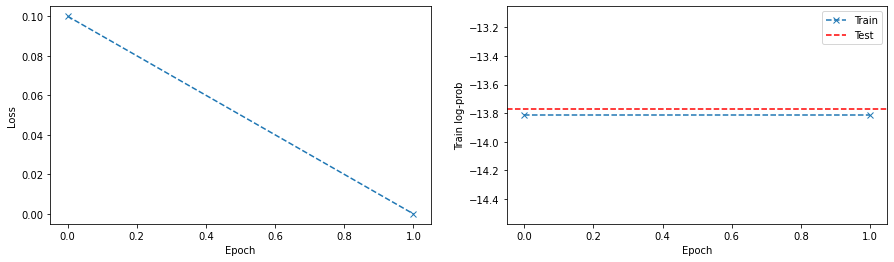

In [28]:
logs = fit_viterbi(hmm=hmm_viterbi, X_train=dataset['train'])
hmm_basic_info(hmm_viterbi)
training_plots(hmm_viterbi, logs['losses'], logs['probas'], dataset['test'])

# Zadanie dodatkowe (1 p.)
Drugim algorytmem uczenia HMM jest algorytm Baum-Welcha (Forward-Backward). Zadanie dodatkowe polega na implementacji tego algorytmu w podobny sposób jak algorytm Viterbiego.


**Dodatkowe źródła**:
- [Forward+Viterbi] https://www.cis.upenn.edu/~cis262/notes/Example-Viterbi-DNA.pdf
- [Full intro to HMM + Forward + Viterbi] https://www.seas.upenn.edu/~cis262/notes/cis262-hmm.pdf
- [Intro to HMM + Forward + Viterbi + Forward-Backward] http://www.cs.tut.fi/kurssit/SGN-24006/PDF/L08-HMMs.pdf
- [Baum-Welch] https://en.wikipedia.org/wiki/Baum–Welch_algorithm
- [Baum-Welch implementation] http://www.adeveloperdiary.com/data-science/machine-learning/derivation-and-implementation-of-baum-welch-algorithm-for-hidden-markov-model/
- [Forward and backward implementations] http://www.adeveloperdiary.com/data-science/machine-learning/forward-and-backward-algorithm-in-hidden-markov-model/
- [Viterbi implementation] http://www.adeveloperdiary.com/data-science/machine-learning/implement-viterbi-algorithm-in-hidden-markov-model-using-python-and-r/